# Eaters world

Scroll down to the "Start here" cell.



Like PACMAN where *eaters* 


we've got this move to food program but its dumb, only senses whats around it
this is a problem, the eater will stop when theres nothing immediately around it

p53 pic of not knowing what to do 




In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src/')

from lib.pysoarlib import *
import os
from random import choice, randint

# Visualization
from PIL import Image, ImageDraw, ImageFont
from IPython import display
from time import sleep

# Current working directory (.../tutorials)
cwd = os.path.abspath('')
font_sm = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf", 14, encoding="unic")

In [3]:
class Food():
    def __init__(self, bonus=False):
        self.points = 10   if bonus else 5
        self.color = 'red' if bonus else 'blue'
        self.bonus = bonus
    def __repr__(self):
        return 'bonusfood' if self.bonus else 'normalfood'
    
    
class Blank():
    def __init__(self):
        pass
    def __repr__(self):
        return 'blank'

    
class Wall():
    def __init__(self):
        pass
    def __repr__(self):
        return 'wall'
    
class GridBuilder:
    def __init__(self, world_type, rows, cols):
        self.rows = rows
        self.cols = cols
        self.grid = [[Blank() for x in range(cols)] for y in range(rows)] 
        
        if world_type == 'all food':
            self._add_random_food()
        elif world_type == 'random':
            # Initialize grid with walls/blank squares
            self._add_random_walls()
            # Fill the rest with food
            self._add_random_food(blank_only=True)
        else:
            raise Exception("Unknown world type")

    def get_iter(self):
        flatten = lambda t: [item for sublist in t for item in sublist]
        return flatten([[(row, col) for col in range(self.cols)] for row in range(self.rows)] )

    def _add_random_walls(self):
        choices = [Wall(), Blank(), Blank(), Blank(), Blank()]
        for row, col in self.get_iter():
            self.grid[row][col] = choice(choices)
        
    def _add_random_food(self, blank_only=False):
        for row, col in self.get_iter():
            if (blank_only and isinstance(self.grid[row][col], Blank)) or not blank_only:
                self.grid[row][col] = choice([Food(bonus=True), Food(bonus=False)])
     
    
# action_space = ['north', 'east', 'south', 'west']
class World():    
    def __init__(self, display, world_type, width=300, height=300, rows=16, cols=16):
        self.n_rows = rows
        self.n_cols = cols
        self.width = width
        self.height = height
        
        builder = GridBuilder(world_type, rows, cols)
        self.grid = builder.grid

            
            
        self.image = Image.new("RGBA", (self.width, self.height), (255, 255, 255, 0))
        self.canvas = ImageDraw.Draw(self.image)
        self.display = display
        self.cell_w = self.width / cols
        self.cell_h = self.width / rows
        
    def place_eaters(self, eaters):
        # Place the eaters randomly
        for eater in eaters:
            while True:
                row, col = randint(0, self.n_rows - 1), randint(0, self.n_cols - 1)
                if not isinstance(self.grid[row][col], Wall):
                    self.grid[row][col] = eater
                    break

    def step(self, ID: str, action = None):
        """ Returns (observations, reward) """
        ((row_n, col_n), cell) = self.find(ID)
        
        new_row = row_n
        new_col = col_n
        if action == 'north': new_row -= 1
        if action == 'south': new_row += 1
        if action == 'west' : new_col -= 1
        if action == 'east' : new_col += 1
        
        no_move = new_row == row_n and new_col == col_n
        if not self.is_valid_move(new_row, new_col) or no_move:
            # Don't move and return current observations
            return self.observations(row_n, col_n), 0
        
        if self.is_collision((row_n, col_n), (new_row, new_col)):
            raise Exception("no logic to handle collisions")
        else:        
            # aka reward
            points = 0
            if hasattr(self.grid[new_row][new_col], 'points'):
                points = self.grid[new_row][new_col].points
            self.grid[new_row][new_col] = self.grid[row_n][col_n]
            self.grid[row_n][col_n] = Blank()
            return self.observations(new_row, new_col), points


    def is_valid_move(self, row, col):
        # Out of bounds
        if row < 0 or col < 0 or row >= self.n_rows or col >= self.n_cols:
            return False
        is_wall = isinstance(self.grid[row][col], Wall)
        return not is_wall
        
    def is_collision(self, pos1, pos2):
        eater_1 = self.grid[pos1[0]][pos1[1]]
        eater_2 = self.grid[pos2[0]][pos2[1]]
        return isinstance(eater_1, Eater) and isinstance(eater_2, Eater) and eater_1.ID != eater_2.ID
        
    def observations(self, row, col):
        north = '' if row == 0           else self.grid[row - 1][col]
        south = '' if row >= self.n_rows-1 else self.grid[row + 1][col]
        east = ''  if col >= self.n_cols-1 else self.grid[row][col + 1]
        west = ''  if col == 0           else self.grid[row][col - 1]
        return {
            'north' : str(north),
            'south' : str(south),
            'east'  : str(east),
            'west'  : str(west),
        }
    
    def find(self, ID: str): 
        for row_n, row in enumerate(self.grid):
            for col_n, cell in enumerate(row):
                if hasattr(cell, 'ID') and cell.ID == ID:
                    return ((row_n, col_n), cell)
        raise Exception(f"Couldn't find {ID}")
        
    def draw(self):
        for y, row in enumerate(self.grid):
            for x, cell in enumerate(row):
                rect = (x * self.cell_w, y * self.cell_h, self.cell_w, self.cell_h)
                if isinstance(cell, Blank):
                    self._draw_rect(rect, fill='white')
                if isinstance(cell, Wall):
                    self._draw_rect(rect, fill='black')
                if isinstance(cell, Eater):
                    self._draw_rect(rect, fill=cell.color)
                    self._center_text(rect, font_sm, str(cell.points))
                if isinstance(cell, Food):
                    padding = .30 * self.cell_w
                    x_pos, y_pos = x * self.cell_w + padding, y * self.cell_h + padding
                    w = self.cell_w - (padding * 2)
                    h = self.cell_h - (padding * 2)
                    self._draw_circle((x_pos, y_pos, w, h), fill=cell.color)
        
        self.display.update(self.image)
    
    ####### Private
    def _draw_circle(self, bg, fill: str, outline: str = 'black'):
        x, y, width, height = bg
        self.canvas.ellipse((x, y, x + width, y + height), fill = fill, outline = outline)

    def _draw_rect(self, bg, fill: str):
        x, y, width, height = bg
        self.canvas.rectangle((x, y, x + width, y + height), fill=fill)
        
    def _center_text(self, bg, font, text, color=(0, 0, 0)):
        x, y, width, height = bg
        text_width, text_height = self.canvas.textsize(text, font)
        position = ((width - text_width)/2 + x, (height - text_height)/2 + y)
        self.canvas.text(position, text, color, font=font)

Propose food is looking for

```
(state <s> ^io.input-link.location.<dir>.content 
    << normalfood bonusfood >>)
```

In [4]:
class Eater():
    def __init__(self, ID: str, agent_raw: str, world: World, watch_level=1):
        """ Initialize eater. ID works as the color too. """
        self.ID = ID
        self.color = ID
        self.points = 0
        self.agent = SoarAgent(
            agent_name=f"agent_{ID}",
            write_to_stdout=True,
            agent_raw=agent_raw,
            watch_level=watch_level,
        )
        self.connector = MoveConnector(self.agent)
        self.agent.add_connector("eater", self.connector)
        self.agent.connect()
        
    def step(self):
        self.agent.execute_command("step")

    def get_move(self):
        move = self.connector.last_move_output
        self.connector.last_move_output = None
        return move
        
    def update_wm_from_observations(self, observations):
        for (direction, contents) in observations.items():
            # Example: connector.contents['north'].set_value('bonusfood')
            self.connector.contents[direction].set_value(contents)
        
        
class MoveConnector(AgentConnector):
    def __init__(self, agent):
        AgentConnector.__init__(self, agent)
        self.move_command = "move"
        self.add_output_command(self.move_command)
        self.last_move_output = None
        self.location_id = None
        self.directions = { 'north': None, 'south': None, 'east': None, 'west': None }
        # content is "bonusfood" | "normalfood" | "wall" | "blank"
        self.contents = {}
        for direction in self.directions.keys():
            self.contents[direction] = SoarWME('content', '')
            

    def on_input_phase(self, input_link):
        if self.location_id is None:
            self.location_id = input_link.CreateIdWME('location')
            for direction in self.directions.keys():
                # Add a <direction> identifier on the location identifier
                self.directions[direction] = self.location_id.CreateIdWME(direction)
                # Add the ^contents attribute to the direction
                # Accessing this in full would lok like location.north.content
                self.contents[direction].add_to_wm(self.directions[direction])
            return
        
        # If the value has changed, will update soar's working memory with the new value
        for direction, contents in self.contents.items():
            contents.update_wm()

    def on_output_event(self, command_name, root_id):
        if command_name == self.move_command:
            self.process_move_command(root_id)
    
    def process_move_command(self, root_id):
        direction = root_id.GetChildString("direction")
        self.last_move_output = direction
        root_id.AddStatusComplete()

In [18]:
def runner(eaters, world_type='random', debug=False, total_ticks=100, tick_speed=1, soar_watch_level=0):
    """
    param eaters:
        list of tuples (color, Soar script)
    """
    d = display.display("z", display_id=True)

    world = World(d, world_type, width=600, height=600, rows=16, cols=16)
    eaters = [Eater(color, script, world, watch_level=soar_watch_level) for (color, script) in eaters]
    world.place_eaters(eaters)

    # Set intial eater WM
    for e in eaters:
        pos, cell = world.find(e.ID)    
        observations = world.observations(pos[0], pos[1])
        e.update_wm_from_observations(observations)
        e.step()
        
    debug_on = debug
    debug = lambda x: print(x) if debug_on else 0

    world.draw()
    for i in range(total_ticks):
        debug('==============================================================================')
        debug('==============================================================================')
        debug(f'============================== WORLD TICK {i} ==================================')
        debug('==============================================================================')
        debug('==============================================================================')
        
        
        for eater in eaters:            
            ### Get observations
            pos, cell = world.find(eater.ID)    
            observations = world.observations(pos[0], pos[1])
            debug(f'\t>>>>>>>>> Eater "{eater.ID}"\'s observations: {observations}')
            
            ### Update eater
            eater.update_wm_from_observations(observations)
            # Propose new move operator
            eater.step()
            # Apply new move operator, triggering an output link
            eater.step()
                
            ### Take action
            action = eater.get_move()
            debug(f'\t>>>>>>>>> Eater "{eater.ID}" chose action {action}')
            
            # TODO: Not sure why adding this makes it work
            # Have to set these to null so that there isn't a 'state no change'
            eater.update_wm_from_observations({
                'north': 'null',
                'south': 'null',
                'east': 'null',
                'west': 'null',
            })

            _, reward = world.step(eater.ID, action)
            eater.points += reward
#             action = eater.get_move()
            
#             debug(f'\t>>>>>>>>> Eater "{eater.ID}" chose action {action}')

#             # TODO: Not sure why adding this makes it work
#             # Have to set these to null so that there isn't a 'state no change'
#             eater.update_wm_from_observations({
#                 'north': 'null',
#                 'south': 'null',
#                 'east': 'null',
#                 'west': 'null',
#             })

#             observations, reward = world.step(eater.ID, action)
            
#             debug(f'\t>>>>>>>>> Eater "{eater.ID}"\'s observations: {observations}')
            
#             eater.points += reward
#             eater.update_wm_from_observations(observations)
#             # Propose new move operator
#             eater.step()
#             # Apply new move operator, triggering an output link
#             eater.step()

        world.draw()
        sleep(tick_speed) 

In [19]:
simple_move_to_food_agent = """
sp {propose*move-to-food
   (state <s> ^io.input-link.location.<dir>.content 
                 << normalfood bonusfood >>)
-->
   (<s> ^operator <o> + =)
   (<o> ^name move-to-food
        ^direction <dir>)}

sp {apply*move-to-food
   (state <s> ^io.output-link <ol>
              ^operator <o>)
   (<o> ^name move-to-food
        ^direction <dir>)
-->
   (<ol> ^move.direction <dir>)}

sp {apply*move-to-food*remove-move
   (state <s> ^io.output-link <ol>
              ^operator.name move-to-food)
   (<ol> ^move <move>)
   (<move> ^status complete)
-->
   (<ol> ^move <move> -)}
"""

simple_move_to_food_with_monitoring = simple_move_to_food_agent + """
sp {eater*monitor*directions
    (state <s> ^io.input-link.location.<dir>.content <item>)
-->
    (write (crlf) <dir> | <<<<has item>>>> | <item>)}
"""

# Start Here

TODO explain eater world

Run the cell below a few times to see a simple eater in action.

All this eater does is sense the four squares around it. 
If one of the squares contains food, it moves towards it.
Notice how these simple rules will cause an eater to get stuck if it cannot sense any food.

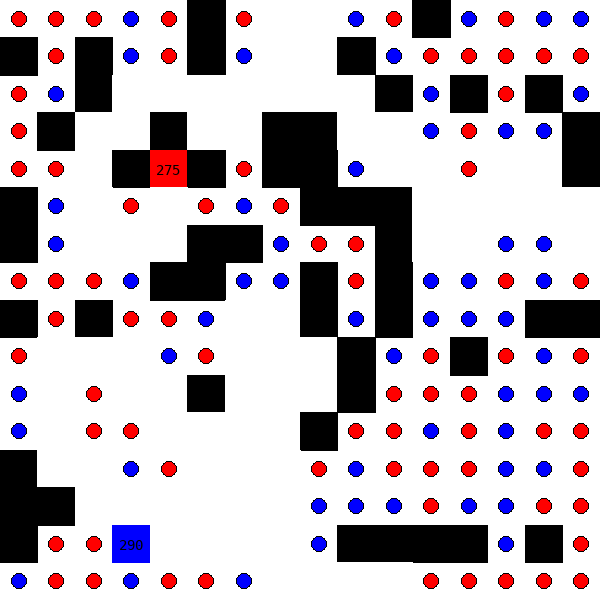

--------- SOURCING PRODUCTIONS ------------
Total: 3 productions sourced.
--------- SOURCING PRODUCTIONS ------------
Total: 3 productions sourced.
--- Input Phase ---
=>WM: (22: W1 ^content bonusfood)
=>WM: (21: L2 ^west W1)
=>WM: (20: E2 ^content bonusfood)
=>WM: (19: L2 ^east E2)
=>WM: (18: I4 ^content )
=>WM: (17: L2 ^south I4)
=>WM: (16: N1 ^content wall)
=>WM: (15: L2 ^north N1)
=>WM: (14: I2 ^location L2)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing propose*move-to-food

Firing propose*move-to-food
+ (O2 ^direction east +) (propose*move-to-food)
+ (O2 ^name move-to-food +) (propose*move-to-food)
+ (S1 ^operator O2 =) (propose*move-to-food)
+ (S1 ^operator O2 +) (propose*move-to-food)
+ (O1 ^direction west +) (propose*move-to-food)
+ (O1 ^name move-to-food +) (propose*move-to-food)
+ (S1 ^operator O1 =) (propose*move-to-food)
+ (S1 ^operator O1 +) (propose*move-to-food)
=>WM: (28: S1 ^operator O2 +)
=>WM: (27: S1

============================== WORLD TICK 1 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': 'normalfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M2 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M2 ^direction west +  :O ) (apply*move-to-food)
<=WM: (43: M2 ^direction west)
<=WM: (45: M2 ^status complete)
<=WM: (44: I3 ^move M2)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (63: W1 ^content normalfood)
=>WM: (62: E2 ^content blank)
=>WM: (61: I4 ^content )
=>WM: (60: N1 ^content wall)
<=WM: (35: W1 ^content bonusfood)
<=WM: (34: E2 ^conte

============================== WORLD TICK 2 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'normalfood', 'south': '', 'east': 'blank', 'west': 'bonusfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M3 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M3 ^direction west +  :O ) (apply*move-to-food)
<=WM: (69: M3 ^direction west)
<=WM: (70: M3 ^status complete)
<=WM: (68: I3 ^move M3)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (88: W1 ^content bonusfood)
=>WM: (87: E2 ^content blank)
=>WM: (86: I4 ^content )
=>WM: (85: N1 ^content normalfood)
<=WM: (63: W1 ^content normalfood)
<=WM: (62

============================== WORLD TICK 3 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'normalfood', 'south': '', 'east': 'blank', 'west': 'normalfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M4 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M4 ^direction west +  :O ) (apply*move-to-food)
<=WM: (97: M4 ^direction west)
<=WM: (98: M4 ^status complete)
<=WM: (96: I3 ^move M4)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (116: W1 ^content normalfood)
=>WM: (115: E2 ^content blank)
=>WM: (114: I4 ^content )
=>WM: (113: N1 ^content normalfood)
<=WM: (88: W1 ^content bonusfood)
<=WM

============================== WORLD TICK 4 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'normalfood', 'south': 'blank', 'east': 'normalfood', 'west': 'bonusfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M5 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M5 ^direction north +  :O ) (apply*move-to-food)
<=WM: (125: M5 ^direction north)
<=WM: (126: M5 ^status complete)
<=WM: (124: I3 ^move M5)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (144: W1 ^content bonusfood)
=>WM: (143: E2 ^content normalfood)
=>WM: (142: I4 ^content blank)
=>WM: (141: N1 ^content normalfood)
<=WM: (116: W1 

============================== WORLD TICK 5 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'bonusfood', 'south': 'blank', 'east': 'normalfood', 'west': 'normalfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M6 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M6 ^direction north +  :O ) (apply*move-to-food)
<=WM: (156: M6 ^direction north)
<=WM: (157: M6 ^status complete)
<=WM: (155: I3 ^move M6)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (175: W1 ^content normalfood)
=>WM: (174: E2 ^content normalfood)
=>WM: (173: I4 ^content blank)
=>WM: (172: N1 ^content bonusfood)
<=WM: (144: W1 

============================== WORLD TICK 6 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'bonusfood', 'south': 'bonusfood', 'east': 'blank', 'west': 'bonusfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M7 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M7 ^direction west +  :O ) (apply*move-to-food)
<=WM: (187: M7 ^direction west)
<=WM: (188: M7 ^status complete)
<=WM: (186: I3 ^move M7)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (206: W1 ^content bonusfood)
=>WM: (205: E2 ^content blank)
=>WM: (204: I4 ^content bonusfood)
=>WM: (203: N1 ^content bonusfood)
<=WM: (175: W1 ^conte

============================== WORLD TICK 7 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'blank', 'south': 'normalfood', 'east': 'blank', 'west': 'bonusfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M8 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M8 ^direction south +  :O ) (apply*move-to-food)
<=WM: (218: M8 ^direction south)
<=WM: (219: M8 ^status complete)
<=WM: (217: I3 ^move M8)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (237: W1 ^content bonusfood)
=>WM: (236: E2 ^content blank)
=>WM: (235: I4 ^content normalfood)
=>WM: (234: N1 ^content blank)
<=WM: (206: W1 ^content b

============================== WORLD TICK 8 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'bonusfood', 'south': 'bonusfood', 'east': 'blank', 'west': 'normalfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M9 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M9 ^direction west +  :O ) (apply*move-to-food)
<=WM: (246: M9 ^direction west)
<=WM: (247: M9 ^status complete)
<=WM: (245: I3 ^move M9)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (265: W1 ^content normalfood)
=>WM: (264: E2 ^content blank)
=>WM: (263: I4 ^content bonusfood)
=>WM: (262: N1 ^content bonusfood)
<=WM: (237: W1 ^con

============================== WORLD TICK 9 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'bonusfood', 'south': 'bonusfood', 'east': 'blank', 'west': 'bonusfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M10 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M10 ^direction west +  :O ) (apply*move-to-food)
<=WM: (277: M10 ^direction west)
<=WM: (278: M10 ^status complete)
<=WM: (276: I3 ^move M10)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (296: W1 ^content bonusfood)
=>WM: (295: E2 ^content blank)
=>WM: (294: I4 ^content bonusfood)
=>WM: (293: N1 ^content bonusfood)
<=WM: (265: W1 ^

============================== WORLD TICK 10 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'bonusfood', 'south': 'blank', 'east': 'bonusfood', 'west': 'bonusfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M11 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M11 ^direction north +  :O ) (apply*move-to-food)
<=WM: (308: M11 ^direction north)
<=WM: (309: M11 ^status complete)
<=WM: (307: I3 ^move M11)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (327: W1 ^content bonusfood)
=>WM: (326: E2 ^content bonusfood)
=>WM: (325: I4 ^content blank)
=>WM: (324: N1 ^content bonusfood)
<=WM: (296: W

============================== WORLD TICK 11 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'normalfood', 'south': 'blank', 'east': 'blank', 'west': 'blank'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M12 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M12 ^direction east +  :O ) (apply*move-to-food)
<=WM: (339: M12 ^direction east)
<=WM: (340: M12 ^status complete)
<=WM: (338: I3 ^move M12)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (358: W1 ^content blank)
=>WM: (357: E2 ^content blank)
=>WM: (356: I4 ^content blank)
=>WM: (355: N1 ^content normalfood)
<=WM: (327: W1 ^content bonus

============================== WORLD TICK 12 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'normalfood', 'south': 'blank', 'east': 'bonusfood', 'west': 'bonusfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M13 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M13 ^direction north +  :O ) (apply*move-to-food)
<=WM: (364: M13 ^direction north)
<=WM: (365: M13 ^status complete)
<=WM: (363: I3 ^move M13)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (383: W1 ^content bonusfood)
=>WM: (382: E2 ^content bonusfood)
=>WM: (381: I4 ^content blank)
=>WM: (380: N1 ^content normalfood)
<=WM: (358:

============================== WORLD TICK 13 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'normalfood', 'south': 'blank', 'east': 'bonusfood', 'west': 'blank'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M14 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M14 ^direction east +  :O ) (apply*move-to-food)
<=WM: (395: M14 ^direction east)
<=WM: (396: M14 ^status complete)
<=WM: (394: I3 ^move M14)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (414: W1 ^content blank)
=>WM: (413: E2 ^content bonusfood)
=>WM: (412: I4 ^content blank)
=>WM: (411: N1 ^content normalfood)
<=WM: (383: W1 ^conte

============================== WORLD TICK 14 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'bonusfood', 'south': 'blank', 'east': 'bonusfood', 'west': 'blank'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M15 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M15 ^direction east +  :O ) (apply*move-to-food)
<=WM: (423: M15 ^direction east)
<=WM: (424: M15 ^status complete)
<=WM: (422: I3 ^move M15)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (442: W1 ^content blank)
=>WM: (441: E2 ^content bonusfood)
=>WM: (440: I4 ^content blank)
=>WM: (439: N1 ^content bonusfood)
<=WM: (414: W1 ^content

============================== WORLD TICK 15 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'normalfood', 'south': 'blank', 'east': 'wall', 'west': 'normalfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M16 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M16 ^direction north +  :O ) (apply*move-to-food)
<=WM: (451: M16 ^direction north)
<=WM: (452: M16 ^status complete)
<=WM: (450: I3 ^move M16)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (470: W1 ^content normalfood)
=>WM: (469: E2 ^content wall)
=>WM: (468: I4 ^content blank)
=>WM: (467: N1 ^content normalfood)
<=WM: (442: W1 ^con

============================== WORLD TICK 16 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'normalfood', 'south': 'blank', 'east': 'normalfood', 'west': 'bonusfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M17 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M17 ^direction north +  :O ) (apply*move-to-food)
<=WM: (479: M17 ^direction north)
<=WM: (480: M17 ^status complete)
<=WM: (478: I3 ^move M17)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (498: W1 ^content bonusfood)
=>WM: (497: E2 ^content normalfood)
=>WM: (496: I4 ^content blank)
=>WM: (495: N1 ^content normalfood)
<=WM: (47

============================== WORLD TICK 17 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'bonusfood', 'south': 'wall', 'east': 'wall', 'west': 'blank'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M18 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M18 ^direction east +  :O ) (apply*move-to-food)
<=WM: (510: M18 ^direction east)
<=WM: (511: M18 ^status complete)
<=WM: (509: I3 ^move M18)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (529: W1 ^content blank)
=>WM: (528: E2 ^content wall)
=>WM: (527: I4 ^content wall)
=>WM: (526: N1 ^content bonusfood)
<=WM: (498: W1 ^content bonusfood)


============================== WORLD TICK 18 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': 'blank', 'east': 'wall', 'west': 'normalfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M19 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M19 ^direction north +  :O ) (apply*move-to-food)
<=WM: (535: M19 ^direction north)
<=WM: (536: M19 ^status complete)
<=WM: (534: I3 ^move M19)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (554: W1 ^content normalfood)
=>WM: (553: E2 ^content wall)
=>WM: (552: I4 ^content blank)
=>WM: (551: N1 ^content wall)
<=WM: (529: W1 ^content blank)


============================== WORLD TICK 19 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'normalfood', 'south': 'blank', 'east': 'blank', 'west': 'bonusfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M20 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M20 ^direction west +  :O ) (apply*move-to-food)
<=WM: (560: M20 ^direction west)
<=WM: (561: M20 ^status complete)
<=WM: (559: I3 ^move M20)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (579: W1 ^content bonusfood)
=>WM: (578: E2 ^content blank)
=>WM: (577: I4 ^content blank)
=>WM: (576: N1 ^content normalfood)
<=WM: (554: W1 ^conte

============================== WORLD TICK 20 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'normalfood', 'south': 'blank', 'east': 'wall', 'west': 'normalfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M21 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M21 ^direction north +  :O ) (apply*move-to-food)
<=WM: (588: M21 ^direction north)
<=WM: (589: M21 ^status complete)
<=WM: (587: I3 ^move M21)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (607: W1 ^content normalfood)
=>WM: (606: E2 ^content wall)
=>WM: (605: I4 ^content blank)
=>WM: (604: N1 ^content normalfood)
<=WM: (579: W1 ^con

============================== WORLD TICK 21 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'normalfood', 'south': 'bonusfood', 'east': 'blank', 'west': 'normalfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M22 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M22 ^direction west +  :O ) (apply*move-to-food)
<=WM: (616: M22 ^direction west)
<=WM: (617: M22 ^status complete)
<=WM: (615: I3 ^move M22)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (635: W1 ^content normalfood)
=>WM: (634: E2 ^content blank)
=>WM: (633: I4 ^content bonusfood)
=>WM: (632: N1 ^content normalfood)
<=WM: (607:

============================== WORLD TICK 22 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'blank', 'south': 'bonusfood', 'east': 'blank', 'west': 'bonusfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M23 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M23 ^direction south +  :O ) (apply*move-to-food)
<=WM: (647: M23 ^direction south)
<=WM: (648: M23 ^status complete)
<=WM: (646: I3 ^move M23)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (666: W1 ^content bonusfood)
=>WM: (665: E2 ^content blank)
=>WM: (664: I4 ^content bonusfood)
=>WM: (663: N1 ^content blank)
<=WM: (635: W1 ^conte

============================== WORLD TICK 23 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'blank', 'south': 'normalfood', 'east': 'blank', 'west': 'wall'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M24 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M24 ^direction south +  :O ) (apply*move-to-food)
<=WM: (675: M24 ^direction south)
<=WM: (676: M24 ^status complete)
<=WM: (674: I3 ^move M24)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (694: W1 ^content wall)
=>WM: (693: E2 ^content blank)
=>WM: (692: I4 ^content normalfood)
=>WM: (691: N1 ^content blank)
<=WM: (666: W1 ^content bonus

============================== WORLD TICK 24 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'blank', 'south': 'blank', 'east': 'blank', 'west': 'normalfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M25 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M25 ^direction south +  :O ) (apply*move-to-food)
<=WM: (700: M25 ^direction south)
<=WM: (701: M25 ^status complete)
<=WM: (699: I3 ^move M25)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (719: W1 ^content normalfood)
=>WM: (718: E2 ^content blank)
=>WM: (717: I4 ^content blank)
=>WM: (716: N1 ^content blank)
<=WM: (694: W1 ^content wal

============================== WORLD TICK 26 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'bonusfood', 'south': 'bonusfood', 'east': 'blank', 'west': 'bonusfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M27 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M27 ^direction west +  :O ) (apply*move-to-food)
<=WM: (750: M27 ^direction west)
<=WM: (751: M27 ^status complete)
<=WM: (749: I3 ^move M27)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (769: W1 ^content bonusfood)
=>WM: (768: E2 ^content blank)
=>WM: (767: I4 ^content bonusfood)
=>WM: (766: N1 ^content bonusfood)
<=WM: (744: W1 

============================== WORLD TICK 27 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'normalfood', 'south': 'blank', 'east': 'wall', 'west': 'normalfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M28 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M28 ^direction north +  :O ) (apply*move-to-food)
<=WM: (781: M28 ^direction north)
<=WM: (782: M28 ^status complete)
<=WM: (780: I3 ^move M28)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (800: W1 ^content normalfood)
=>WM: (799: E2 ^content wall)
=>WM: (798: I4 ^content blank)
=>WM: (797: N1 ^content normalfood)
<=WM: (769: W1 ^con

============================== WORLD TICK 28 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'bonusfood', 'south': 'bonusfood', 'east': 'blank', 'west': 'bonusfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M29 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M29 ^direction west +  :O ) (apply*move-to-food)
<=WM: (809: M29 ^direction west)
<=WM: (810: M29 ^status complete)
<=WM: (808: I3 ^move M29)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (828: W1 ^content bonusfood)
=>WM: (827: E2 ^content blank)
=>WM: (826: I4 ^content bonusfood)
=>WM: (825: N1 ^content bonusfood)
<=WM: (800: W1 

============================== WORLD TICK 29 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'bonusfood', 'south': 'blank', 'east': 'normalfood', 'west': 'normalfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M30 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M30 ^direction north +  :O ) (apply*move-to-food)
<=WM: (840: M30 ^direction north)
<=WM: (841: M30 ^status complete)
<=WM: (839: I3 ^move M30)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (859: W1 ^content normalfood)
=>WM: (858: E2 ^content normalfood)
=>WM: (857: I4 ^content blank)
=>WM: (856: N1 ^content bonusfood)
<=WM: (82

============================== WORLD TICK 30 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': 'bonusfood', 'east': 'blank', 'west': 'normalfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M31 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M31 ^direction west +  :O ) (apply*move-to-food)
<=WM: (871: M31 ^direction west)
<=WM: (872: M31 ^status complete)
<=WM: (870: I3 ^move M31)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (890: W1 ^content normalfood)
=>WM: (889: E2 ^content blank)
=>WM: (888: I4 ^content bonusfood)
=>WM: (887: N1 ^content wall)
<=WM: (859: W1 ^content

============================== WORLD TICK 31 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'bonusfood', 'south': 'normalfood', 'east': 'blank', 'west': 'bonusfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M32 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M32 ^direction west +  :O ) (apply*move-to-food)
<=WM: (899: M32 ^direction west)
<=WM: (900: M32 ^status complete)
<=WM: (898: I3 ^move M32)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (918: W1 ^content bonusfood)
=>WM: (917: E2 ^content blank)
=>WM: (916: I4 ^content normalfood)
=>WM: (915: N1 ^content bonusfood)
<=WM: (890: W

============================== WORLD TICK 32 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'blank', 'south': 'normalfood', 'east': 'bonusfood', 'west': 'normalfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M33 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M33 ^direction south +  :O ) (apply*move-to-food)
<=WM: (930: M33 ^direction south)
<=WM: (931: M33 ^status complete)
<=WM: (929: I3 ^move M33)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (949: W1 ^content normalfood)
=>WM: (948: E2 ^content bonusfood)
=>WM: (947: I4 ^content normalfood)
=>WM: (946: N1 ^content blank)
<=WM: (91

============================== WORLD TICK 33 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'blank', 'south': 'bonusfood', 'east': 'bonusfood', 'west': 'normalfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M34 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M34 ^direction south +  :O ) (apply*move-to-food)
<=WM: (961: M34 ^direction south)
<=WM: (962: M34 ^status complete)
<=WM: (960: I3 ^move M34)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (980: W1 ^content normalfood)
=>WM: (979: E2 ^content bonusfood)
=>WM: (978: I4 ^content bonusfood)
=>WM: (977: N1 ^content blank)
<=WM: (949:

============================== WORLD TICK 34 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'blank', 'south': 'wall', 'east': 'bonusfood', 'west': 'wall'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M35 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M35 ^direction south +  :O ) (apply*move-to-food)
<=WM: (992: M35 ^direction south)
<=WM: (993: M35 ^status complete)
<=WM: (991: I3 ^move M35)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (1011: W1 ^content wall)
=>WM: (1010: E2 ^content bonusfood)
=>WM: (1009: I4 ^content wall)
=>WM: (1008: N1 ^content blank)
<=WM: (980: W1 ^content norma

============================== WORLD TICK 35 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'bonusfood', 'south': 'bonusfood', 'east': 'normalfood', 'west': 'blank'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M36 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M36 ^direction east +  :O ) (apply*move-to-food)
<=WM: (1017: M36 ^direction east)
<=WM: (1018: M36 ^status complete)
<=WM: (1016: I3 ^move M36)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (1036: W1 ^content blank)
=>WM: (1035: E2 ^content normalfood)
=>WM: (1034: I4 ^content bonusfood)
=>WM: (1033: N1 ^content bonusfood)
<=WM: 

============================== WORLD TICK 36 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'blank', 'south': 'bonusfood', 'east': 'bonusfood', 'west': 'wall'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M37 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M37 ^direction south +  :O ) (apply*move-to-food)
<=WM: (1048: M37 ^direction south)
<=WM: (1049: M37 ^status complete)
<=WM: (1047: I3 ^move M37)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (1067: W1 ^content wall)
=>WM: (1066: E2 ^content bonusfood)
=>WM: (1065: I4 ^content bonusfood)
=>WM: (1064: N1 ^content blank)
<=WM: (1036: W1 

KeyboardInterrupt: 

In [21]:
eaters = [
    ('blue', simple_move_to_food_agent),
    ('red', simple_move_to_food_agent),
#     ('green', simple_move_to_food_agent),
]

runner(eaters, debug=True, soar_watch_level=5)

## Let's write it ourselves!

So far, our agents haven't interacted with the outside world at all. They have only maintained an internal state that we populated manually. 
Using what we know now, we couldn't create a robot that moved through an office building to give a stapler to an employee.
That would require *sensing* walls around it, *moving* using some path finder algorithm, and some *hand-stapler* mechanism that guided the robot arm to place a stapler on a desk.
In Soar, you'd program the logic `if I have a stapler, and <target> is infront of me, hand them the stapler, else move to target` into the agent. 
You *wouldn't* program the actual *moving* or *sensing* however. This is because Soar is a kernel.

#### The kernel

Soar clarifies that it is *not* an all purposed AI machine. Soar is a "kernel". The linux kernel, for example, isn't a full-fledged operating system. It doesn't have a GUI. It doesn't have a text editor you can use to edit files using a mouse and keyboard. It does, however, provide hooks for someone to build these things ontop of it. It manages low level process scheduling, memory management, and security. 

You can think of Soar in a similar fashion. Soar won't give you a nice library for recognizing object from a camera feed or for moving a robot from one location to another with A*. It does, however, give you hooks to send information to the agent (I sense a wall infront of me) for internal planning and reasoning. Then, rules match the new state 

#### IO

Sending information to a Soar agent is done through an `input-link`. Receiving commands from a Soar agent is done through an `output-link`.

In this section, we'll talk about the two phases of the Soar cycle we left out in the last lesson: input and output phase.

TODO picture of the soar cycle


#### Jargon you may come across

`Sensors / perception mechanism` Anything that gives an agent information about the outside world. For example, in the eaters world, we provide the agent with the perception of the food around it. If this was a robotics problem in the real world, our sensor could be a camera. We could perform object recognition from the camera feed then send that information (object name, position, etc) to the Soar agent.

`Actuators` How agents perform actions to modify the world around them.

### Output Link

Let's begin by writing an agent that just moves in one direction. 

We can accomplish this task with two rules: `propose*move-north`, `apply*move-north`.

```
propose*move-north
If I exist, 
then propose the move-north operator.

apply*move-north
If the move-north operator is selected, 
then generate an output command to move north.
```

Soar agents have an object in WM called `io`. 
This `io` object has two children, `input-link` and `output-link`.
We can add to the `output-link` as a way of creating commands.
In this case, our command is `move`. 
Our `move` can store information itself, like the speed at which we want to move, or direction.

In `apply*move-north`, we want to create this `move` object on the `output-link` with the `direction` as `north`.

![Output link](./img/3_output-link-north.png)

#### Exercise

Try writing the above two rules to propose and apply the `move-north` operator.

In [ ]:
my_move_north_operators = """
sp {propose*move-north 
    # Code here
}

sp {apply*move-north
    # Code here
}
"""

eaters = [('blue', my_move_north_operators)]
# If you have trouble and want to debug, set the soar_watch_level to a number like 3 or 5
# Debug=True will print each world tick and observations for each eater
runner(eaters, soar_watch_level=5, debug=False, total_ticks=4, world_type='all food')

### This space is intentionally left blank to hide the answers

---


### This space is intentionally left blank to hide the answers

---

### This space is intentionally left blank to hide the answers

---


### This space is intentionally left blank to hide the answers

---

### This space is intentionally left blank to hide the answers

---


### This space is intentionally left blank to hide the answers

---

In [ ]:
answer_move_north_operators = """
sp {propose*move-north 
    (state <s> ^type state)
-->
    (<s> ^operator <o> +) 
    (<o> ^name move-north)}

sp {apply*move-north
    (state <s> ^operator <o>
               ^io <io>) 
    (<io> ^output-link <out>)
    (<o> ^name move-north) 
-->
    (<out> ^move <move>) 
    (<move> ^direction north)}
"""

answer_move_north_operators_condense_notation = """
sp {propose*move-north 
    (state <s> ^type state)
-->
    (<s> ^operator <o> +) 
    (<o> ^name move-north)}

sp {apply*move-north
    (state <s> ^operator.name move-north
               ^io.output-link <out>) 
-->
    (<out> ^move.direction north)}
"""

eaters = [('blue', answer_move_north_operators_condense_notation)]
runner(eaters, total_ticks=3, world_type='all food')

Our eater moves... once.

Let's review the rules.

**Propose**
```
sp {propose*move-north 
    (state <s> ^type state)
-->
    (<s> ^operator <o> +) 
    (<o> ^name move-north)}
```
Nothing special here: on state, propose a new operator named `move-north`.

**Apply**
```
sp {apply*move-north
    (state <s> ^operator <o>
               ^io <io>)        # ^io must be matched to get to the output-link
    (<io> ^output-link <out>)   # ^output-link gives path to identifier for action
    (<o> ^name move-north) 
-->
    (<out> ^move <move>)        # Add command to output-link to move north
    (<move> ^direction north)}
```

We've seen the whole `match a state to an operator named "my-operator"` before. 
Above, the new addition is matching on a state with an `io` object (and subsequently throwing that into the `<io>` variable).
We then see if our matched `<io>` has the attribute `^output-link`.

In the "then" portion, we add an object to the `<out>` output-link. 
This object is a command named `move` that carries additional information about the direction in which the agent wants to move.

If you go into the `Eater` class provided to you, you'll see that we are initializing an agent connector. The connector handles the logic for listening to commands named `move`.

```
self.move_command = "move"
self.add_output_command(self.move_command)
```

Once that has been added, whenever the agent adds `move` to the `output-link`, the following function will be called.

```
def on_output_event(self, command_name, root_id):
    if command_name == self.move_command:
        direction = root_id.GetChildString("direction")
        self.last_move_output = direction
        root_id.AddStatusComplete()
```

In our Soar rule, when we add `move` to the `output-link`, we also add `direction` to `move`. 
The line `direction = root_id.GetChildString("direction")` saves the value of the `direction` object into a variable.

Finally, we save the move output for later. In `runner` there is simple loop. 

1. Grab the `last_move_output` from each eater
2. Move the eater in the world according to the direction
3. 



(See the above *condensed* version for a more succinct way to write the same thing.)

The world class consists of

The Eater class
    TODO maybe should refactor this to have the actuator/perception?

The connector class has two new things